In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Setup folders and inputs

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# Folders to keep outputs tidy
import os, pathlib
BASE = pathlib.Path("/kaggle/working")
for p in ["reports/figures", "models"]:
    (BASE / p).mkdir(parents=True, exist_ok=True)
    
# Input data files are available in the read-only "/kaggle/input" directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, accuracy_score, classification_report,
                             confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay,
                             ConfusionMatrixDisplay, brier_score_loss)
from sklearn.calibration import CalibrationDisplay



import joblib
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Loading data + basic cleaning

In [3]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test  = pd.read_csv("/kaggle/input/titanic/test.csv")

# Good hygiene: remove infinities if any
for df in (train, test):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Quick sanity checks
display(train.head(3))
print("Train dataset Shape: ")
print(train.shape)
print("\nTrain dataset Null Value sorted in a descending order: ")
print(train.isna().sum().sort_values(ascending=False).head(10))

print("\nClass Balance for the \"Survived\" column, with 1=Survived and 0=Did not survive")
train['Survived'].value_counts(normalize=True).rename('class balance')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Train dataset Shape: 
(891, 12)

Train dataset Null Value sorted in a descending order: 
Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
dtype: int64

Class Balance for the "Survived" column, with 1=Survived and 0=Did not survive


Survived
0    0.616162
1    0.383838
Name: class balance, dtype: float64

# Exploring the data

In [4]:
print("train dataset info: ")
print(train.info())

train dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [5]:
print("train dataset describe: ")
print(train.describe())

train dataset describe: 
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


## Missing values analysis

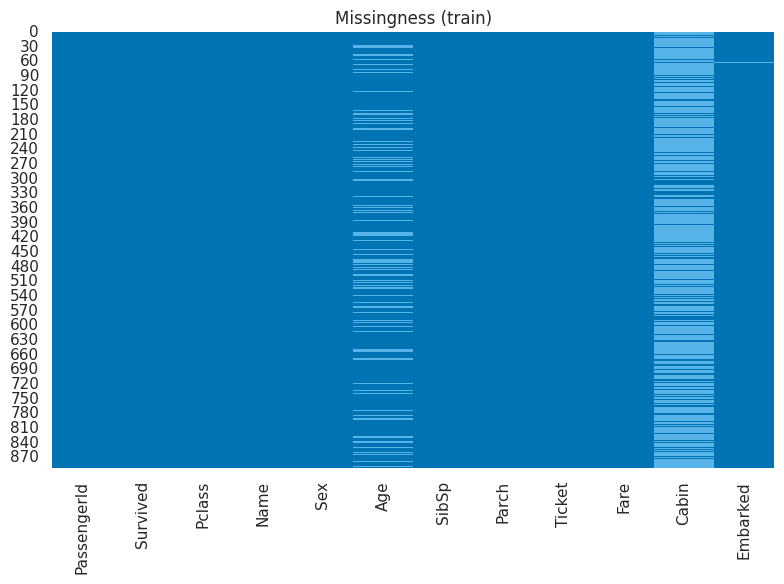

In [6]:
# Missingness map
plt.figure(figsize=(8,6))
# sns.heatmap(train.isna(), cbar=False)
# sns.heatmap(train.isna(), cbar=False, cmap="flare")
palette = sns.color_palette("colorblind")
sns.heatmap(train.isna(), cbar=False, cmap=palette)
plt.title("Missingness (train)")
plt.tight_layout()
plt.savefig(BASE / "reports/figures/01_missingness.png", dpi=150)
plt.show()

Age and Cabin have the most missing values, while Embarked has a few. Cabin is highly incomplete, so it’s better to engineer “HasCabin” instead of using it directly.

## Survival by Sex and Pclass

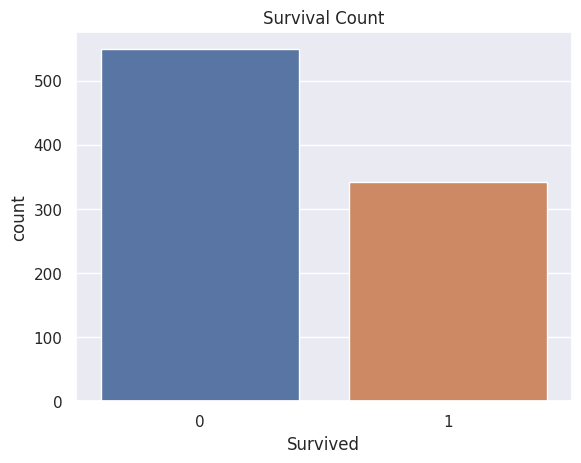

In [7]:
# Survival counts
sns.countplot(x="Survived", data=train)
plt.title("Survival Count")
plt.show()

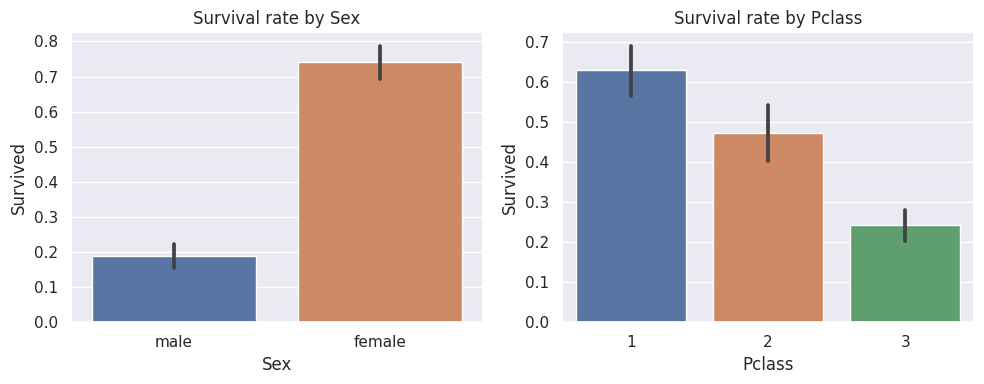

In [8]:
# Survival by Sex and Pclass
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(x="Sex", y="Survived", data=train, ax=ax[0])
ax[0].set_title("Survival rate by Sex")
sns.barplot(x="Pclass", y="Survived", data=train, ax=ax[1])
ax[1].set_title("Survival rate by Pclass")
plt.tight_layout()
plt.savefig(BASE / "reports/figures/02_survival_by_sex_pclass.png", dpi=150)
plt.show()

Females had a much higher survival rate (\~74%) compared to males (\~19%), confirming the “women and children first” rule.

First-class passengers had much higher survival rates than second and third class, showing the strong effect of socio-economic status.

## Age & Fair distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


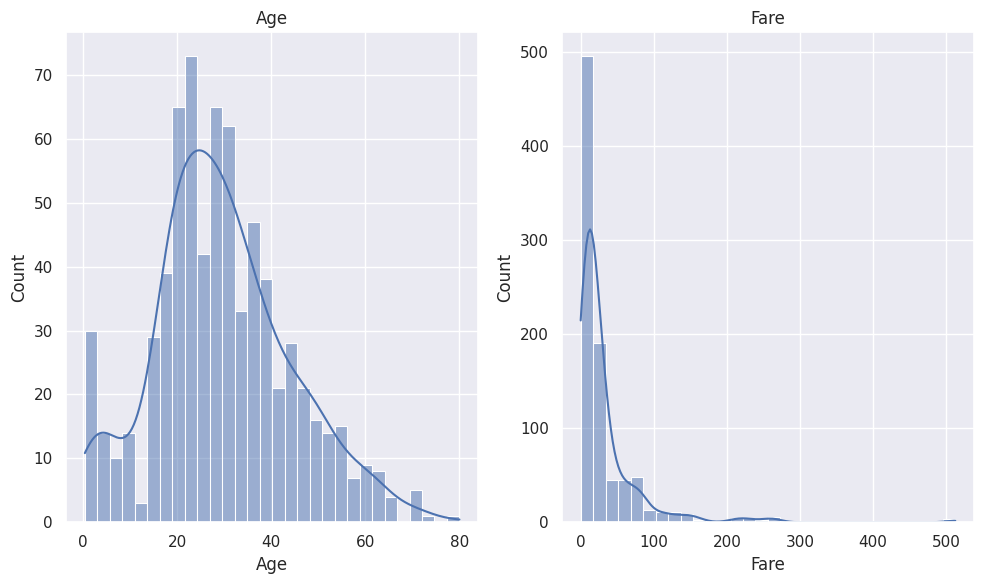

In [9]:
# Age & Fare distributions
fig, ax = plt.subplots(1,2, figsize=(10,6))
sns.histplot(train['Age'], bins=30, kde=True, ax=ax[0])
ax[0].set_title("Age")
sns.histplot(train['Fare'], bins=30, kde=True, ax=ax[1])
ax[1].set_title("Fare")
plt.tight_layout()
plt.savefig(BASE / "reports/figures/03_age_fare.png", dpi=150)
plt.show()

Most passengers were between 20–40 years old, but survival advantage is seen for younger children.

Fares are heavily right-skewed with a few very expensive tickets; higher fares tend to correspond to higher survival rates.

## Survival by Embarked (port of departure)

Did survival differ depending on where passengers boarded?

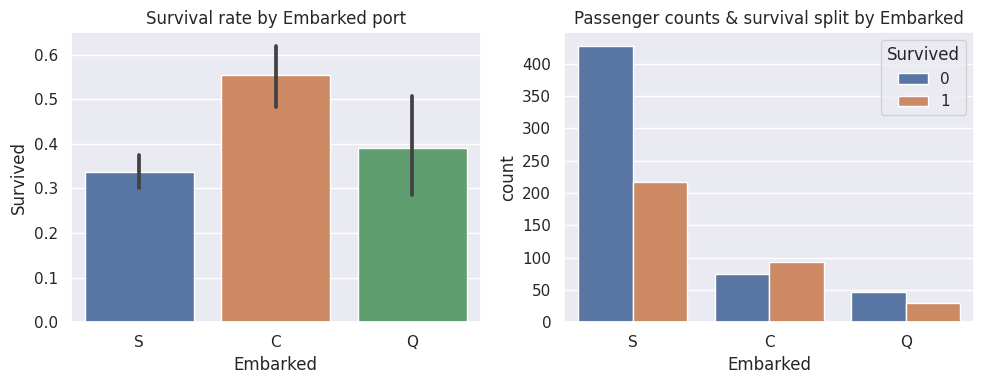

In [10]:
# Survival by Embarked (port of departure)
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(x="Embarked", y="Survived", data=train, estimator=np.mean,  ax=ax[0])
ax[0].set_title("Survival rate by Embarked port")
sns.countplot(x="Embarked", hue="Survived", data=train,  ax=ax[1])
ax[1].set_title("Passenger counts & survival split by Embarked")
plt.tight_layout()
plt.savefig(BASE / "reports/figures/04_survival_by_Embarked.png", dpi=150)
plt.show()

Passengers boarding from Cherbourg had better survival rates than those from Southampton or Queenstown, likely reflecting ticket class differences.

## Survival by Age Group

Did children have a higher survival rate?

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


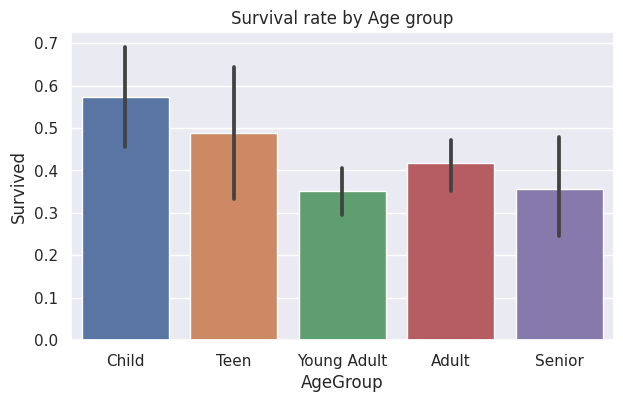

In [11]:
bins = [0, 12, 18, 30, 50, 80]
labels = ["Child","Teen","Young Adult","Adult","Senior"]
train["AgeGroup"] = pd.cut(train["Age"], bins=bins, labels=labels, right=False)

plt.figure(figsize=(7,4))
sns.barplot(x="AgeGroup", y="Survived", data=train)
plt.title("Survival rate by Age group")
plt.savefig(BASE / "reports/figures/05_survival_by_age_group.png", dpi=150)
plt.show()


Children had the highest survival, while survival gradually decreased with age, especially for older adults.

## Family Size vs Survival 

Were small families more likely to survive than people traveling alone or very large families?

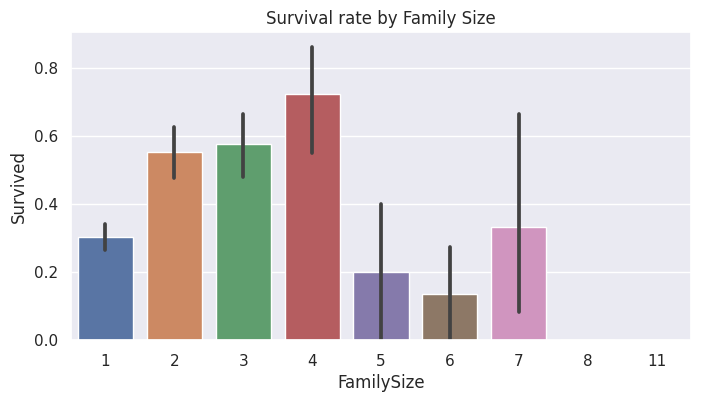

In [12]:
train_fe = train.copy()
train_fe["FamilySize"] = train_fe["SibSp"] + train_fe["Parch"] + 1

plt.figure(figsize=(8,4))
sns.barplot(x="FamilySize", y="Survived", data=train_fe)
plt.title("Survival rate by Family Size")
plt.savefig(BASE / "reports/figures/06_survival_by_family_size.png", dpi=150)
plt.show()

Small families (2–4 people) had better survival odds than those traveling alone or in very large groups.

## Fare distribution by survival 
Did people who paid higher fares (wealthier) have better survival rates?

/tmp/ipykernel_13/3263811661.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_survival = train.groupby("FareBin")["Survived"].mean().reset_index()
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


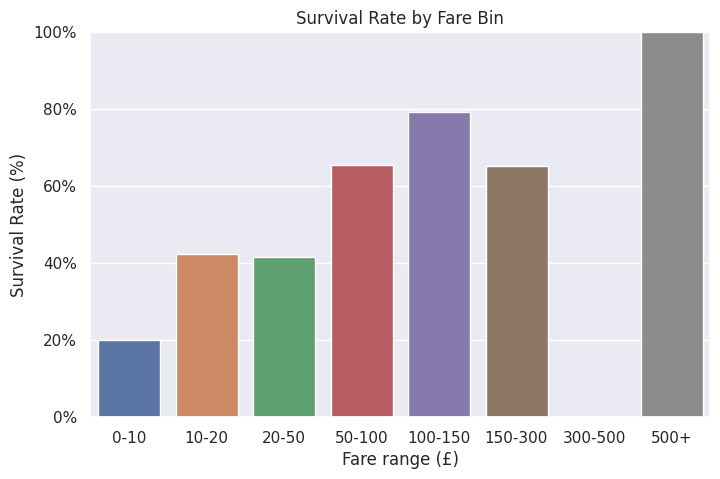

In [13]:
# Create fare bins 
fare_bins = [0, 10, 20, 50, 100, 150, 300, 500, 700]
fare_labels = ["0-10", "10-20", "20-50", "50-100", "100-150", "150-300", "300-500", "500+"]



train["FareBin"] = pd.cut(train["Fare"], bins=fare_bins, labels=fare_labels, include_lowest=True)

# Compute survival % by bin
fare_survival = train.groupby("FareBin")["Survived"].mean().reset_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="FareBin", y="Survived", data=fare_survival)
plt.ylabel("Survival Rate (%)")
plt.xlabel("Fare range (£)")
plt.ylim(0,1)
plt.title("Survival Rate by Fare Bin")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.savefig(BASE / "reports/figures/07_survival_by_fare_group.png", dpi=150)
plt.show()



## Survival by Class and Sex

Did “women and children first” apply across all classes?

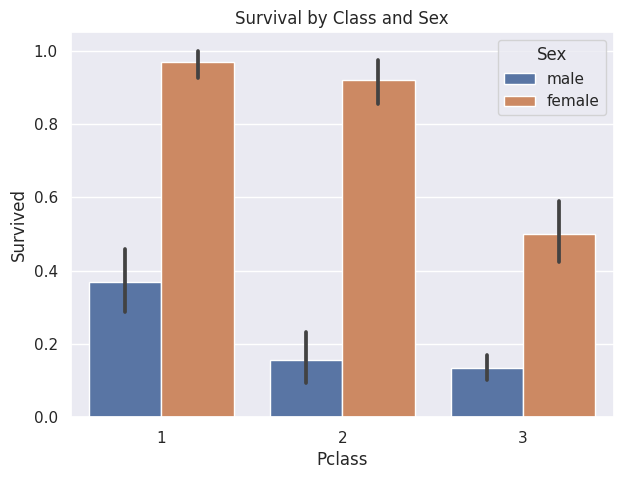

In [14]:
plt.figure(figsize=(7,5))
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=train)
plt.title("Survival by Class and Sex")
plt.savefig(BASE / "reports/figures/08_survival_by_class_sex.png", dpi=150)
plt.show()


Across all classes, women survived more than men, but class amplified survival: 1st class women had the highest chance of survival, 3rd class men the lowest.

## Correlation heatmap

Which numeric features correlate most with survival?

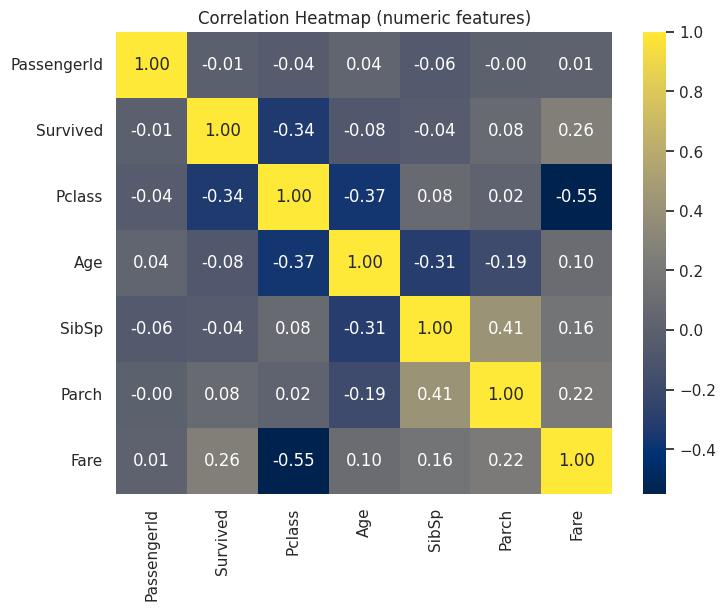

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="cividis", fmt=".2f")
plt.title("Correlation Heatmap (numeric features)")
plt.savefig(BASE / "reports/figures/09_correlation_heatmap.png", dpi=150)
plt.show()


Survival shows the strongest positive correlation with Fare and the strongest negative correlation with Pclass, while most other numeric features (Age, SibSp, Parch) have only weak relationships with survival.

## Survival rate by title

Did certain social roles (Mrs, Miss, Master) have much higher survival?

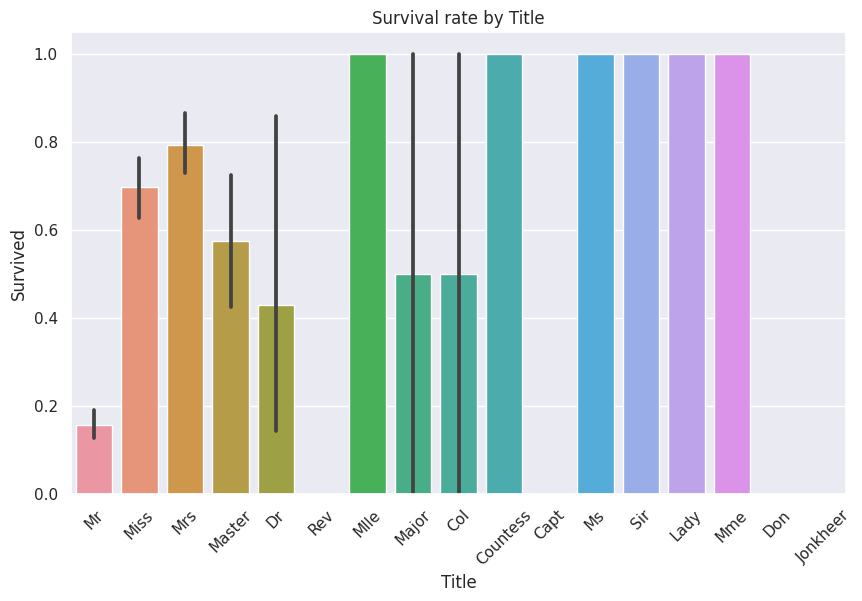

In [16]:
train["Title"] = train["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
title_counts = train["Title"].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x="Title", y="Survived", data=train, order=title_counts.index)
plt.title("Survival rate by Title")
plt.xticks(rotation=45)
plt.savefig(BASE / "reports/figures/10_correlation_heatmap.png", dpi=150)
plt.show()

Titles extracted from names reveal patterns: “Mrs”, “Miss”, and “Master” had higher survival than “Mr” and rare titles, capturing social norms on board. Also titles that correspond to females have higher survival rate. 

# Feature Engineering

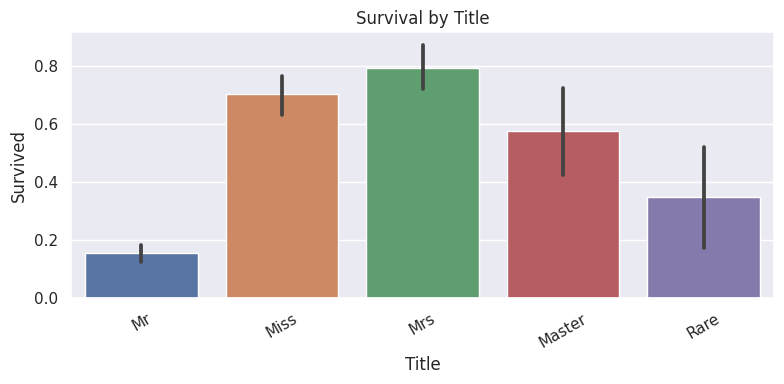

In [17]:
# Build once, reuse on train & test
def add_features(df, ticket_counts_ref=None):
    out = df.copy()

    # Title from Name
    out["Title"] = out["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
    title_map = {
        "Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs",
        "Lady":"Royalty", "Countess":"Royalty", "Sir":"Royalty", "Don":"Royalty", "Jonkheer":"Royalty",
        "Dr":"Rare", "Rev":"Rare", "Col":"Rare", "Major":"Rare", "Capt":"Rare"
    }
    out["Title"] = out["Title"].replace(title_map)
    out["Title"] = np.where(out["Title"].isin(["Mr","Mrs","Miss","Master"]), out["Title"], "Rare")

    # Family features
    out["FamilySize"] = out["SibSp"] + out["Parch"] + 1
    out["IsAlone"] = (out["FamilySize"] == 1).astype(int)

    # Cabin-based features
    out["CabinDeck"] = out["Cabin"].str[0]
    out["HasCabin"] = (~out["Cabin"].isna()).astype(int)

    # Group features from Ticket
    if ticket_counts_ref is None:
        # Build counts from this df only
        counts = out["Ticket"].value_counts()
    else:
        # Use a reference counts mapping (train+test combined, no label leakage)
        counts = ticket_counts_ref
    out["GroupSize"] = out["Ticket"].map(counts).fillna(1).astype(int)
    out["FarePerPerson"] = out["Fare"] / out["GroupSize"]

    return out

# Use combined ticket counts to avoid inconsistencies
ticket_counts_ref = pd.concat([train["Ticket"], test["Ticket"]]).value_counts()

train_fe = add_features(train, ticket_counts_ref)
test_fe  = add_features(test, ticket_counts_ref)

# Quick check: Title survival
plt.figure(figsize=(8,4))
sns.barplot(x="Title", y="Survived", data=train_fe, order=train_fe["Title"].value_counts().index)
plt.title("Survival by Title")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(BASE / "reports/figures/11_survival_by_title.png", dpi=150)
plt.show()


# Feature Definition & Preprocessing

In [18]:
# Treat Pclass as categorical
num_feats = ["Age","Fare","FarePerPerson","SibSp","Parch","FamilySize"]
cat_feats = ["Sex","Embarked","Pclass","Title","CabinDeck","IsAlone","HasCabin"]

X = train_fe[num_feats + cat_feats]
y = train_fe["Survived"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), num_feats),

        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_feats),
    ]
)


# Baselines with proper Cross-Validation: Models evaluations

In [19]:
def cv_report(pipe, X, y, name):
    auc = cross_val_score(pipe, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
    acc = cross_val_score(pipe, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
    return {
        "model": name,
        "roc_auc_mean": auc.mean(), "roc_auc_std": auc.std(),
        "acc_mean": acc.mean(), "acc_std": acc.std()
    }

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (linear)": SVC(kernel="linear", probability=True, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pipelines = {name: Pipeline([("pre", preprocess), ("model", model)]) 
             for name, model in models.items()}

# leaderboard = []
# for name, model in models.items():
#     pipe = Pipeline([("pre", preprocess), ("model", model)])
#     leaderboard.append(cv_report(pipe, X, y, name))

# leaderboard = pd.DataFrame(leaderboard).sort_values("roc_auc_mean", ascending=False)
# leaderboard

leaderboard = []
for name, pipe in pipelines.items():
    auc = cross_val_score(pipe, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
    acc = cross_val_score(pipe, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
    leaderboard.append({
        "model": name,
        "roc_auc_mean": auc.mean(), "roc_auc_std": auc.std(),
        "acc_mean": acc.mean(), "acc_std": acc.std()
    })

leaderboard = pd.DataFrame(leaderboard).sort_values("roc_auc_mean", ascending=False)
leaderboard

,model,roc_auc_mean,roc_auc_std,acc_mean,acc_std
5,GradientBoosting,0.883255,0.016789,0.841724,0.019452
4,RandomForest,0.875228,0.028898,0.821518,0.020141
0,LogisticRegression,0.869058,0.025011,0.820407,0.013053
2,KNN,0.862482,0.025422,0.817030,0.027826
3,SVM (linear),0.850805,0.008282,0.822666,0.018706
1,DecisionTree,0.792945,0.015686,0.799071,0.025682


## 

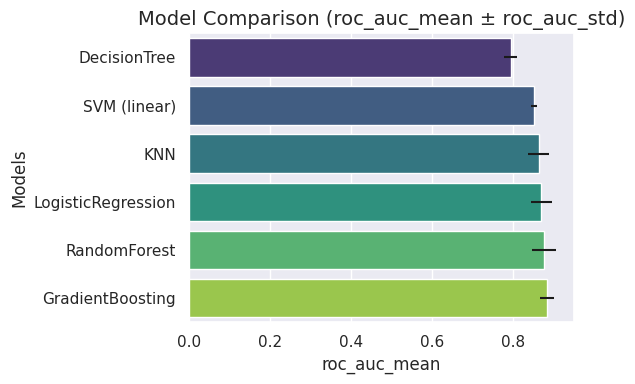

<Figure size 640x480 with 0 Axes>

In [20]:
def plot_leaderboard(df, metric="roc_auc_mean", err="roc_auc_std"):
    # Sort by metric for nicer ordering
    df_sorted = df.sort_values(metric, ascending=True)

    plt.figure(figsize=(6,4))
    sns.barplot(
        x=metric, 
        y="model", 
        data=df_sorted,
        xerr=df_sorted[err],   # add error bars
        capsize=0.2, 
        palette="viridis"
    )

    plt.title(f"Model Comparison ({metric} ± {err})", fontsize=14)
    plt.xlabel(metric)
    plt.ylabel("Models")
    plt.tight_layout()
    plt.show()


plot_leaderboard(leaderboard, metric="roc_auc_mean", err="roc_auc_std")
plt.savefig(BASE / "reports/figures/20_leaderboard.png", dpi=150)

I compared several models with 5-fold stratified cross-validation.
Random Forest and Gradient Boosting outperformed Logistic Regression, while KNN and Decision Tree were weaker.
The error bars show variability across folds: smaller bars = more stable model.

In [21]:
def evaluate_model(pipe, X, y, model_name, test_size=0.2):
    from sklearn.model_selection import train_test_split
    
    # Holdout split
    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=RANDOM_STATE
    )
    
    # Fit
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_val)[:,1]
    pred  = (proba >= 0.5).astype(int)

    # Metrics
    print(f"=== {model_name} Evaluation ===")
    print("ROC-AUC:", roc_auc_score(y_val, proba))
    print("Accuracy:", accuracy_score(y_val, pred))
    print(classification_report(y_val, pred))
    print("Brier score:", brier_score_loss(y_val, proba))

    # Plots
    fig, ax = plt.subplots(1,3, figsize=(15,4))
    RocCurveDisplay.from_predictions(y_val, proba, ax=ax[0]); ax[0].set_title("ROC curve")
    PrecisionRecallDisplay.from_predictions(y_val, proba, ax=ax[1]); ax[1].set_title("PR curve")
    ConfusionMatrixDisplay.from_predictions(y_val, pred, ax=ax[2]); ax[2].set_title("Confusion matrix")
    plt.tight_layout()
    plt.savefig(BASE / f"reports/figures/50_{model_name}_plots.png", dpi=150)
    plt.show()

    disp = CalibrationDisplay.from_predictions(y_val, proba, n_bins=10)
    plt.title(f"Calibration curve: {model_name}")
    plt.savefig(BASE / f"reports/figures/50_{model_name}_calibration_curve.png", dpi=150)
    plt.show()


In [22]:
best_name = leaderboard.iloc[0]["model"]
best_pipe = pipelines[best_name]  # <— directly fetch from dict
print(f"Chosen model: {best_name}")

Chosen model: GradientBoosting


=== GradientBoosting Evaluation ===
ROC-AUC: 0.8496047430830039
Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179

Brier score: 0.13755476396348387


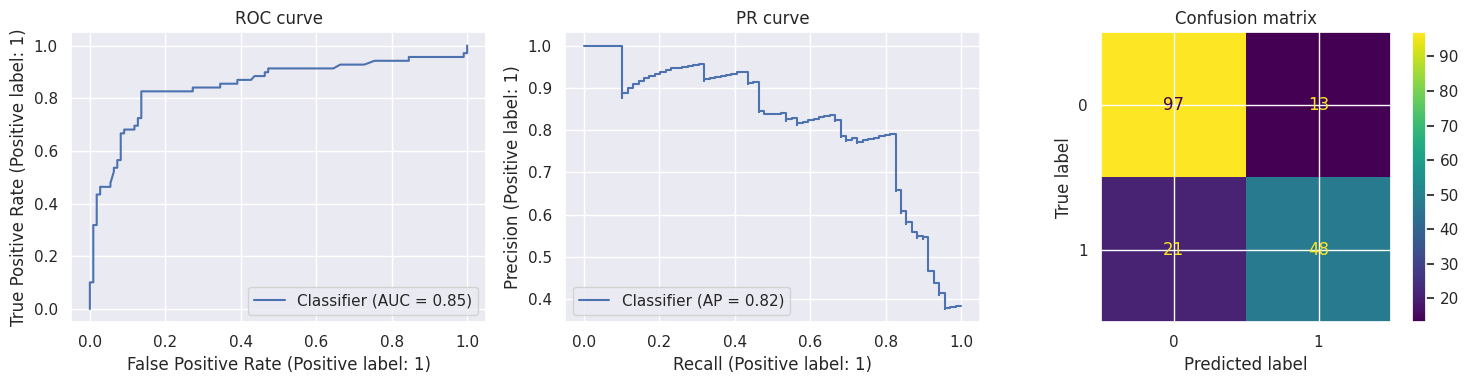

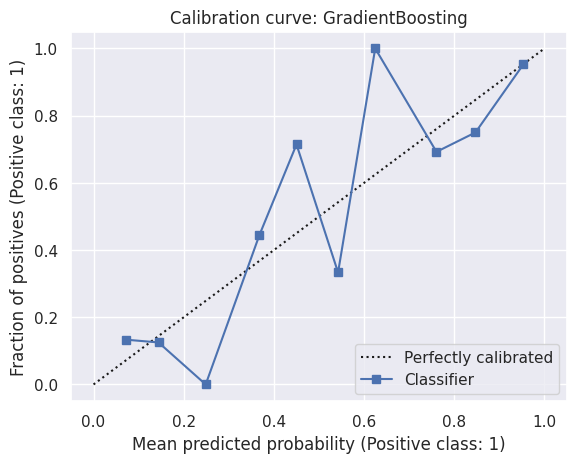

In [23]:
# Best model
evaluate_model(pipelines[best_name], X, y, best_name)

Chosen model: RandomForest
=== RandomForest Evaluation ===
ROC-AUC: 0.8296442687747037
Accuracy: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179

Brier score: 0.1550751219085931


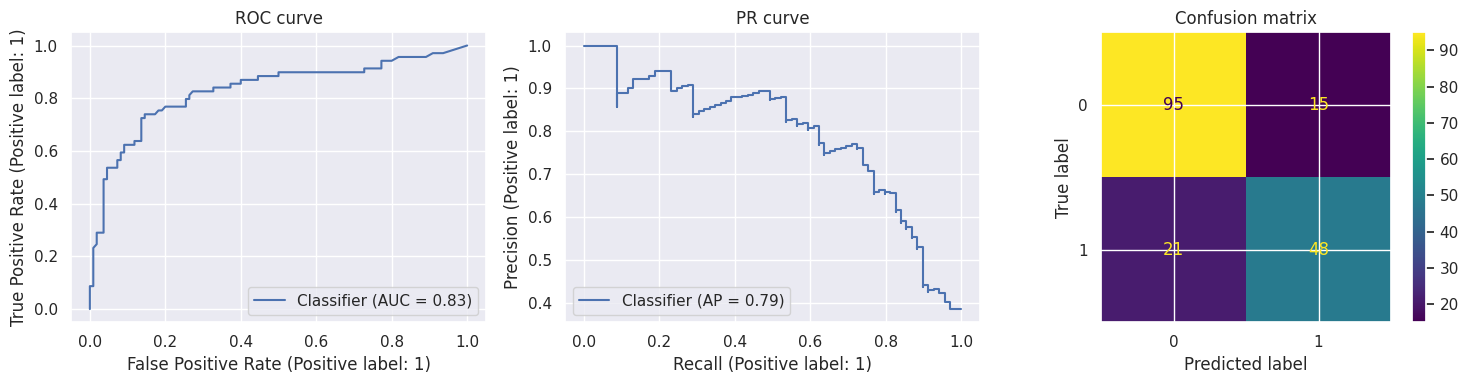

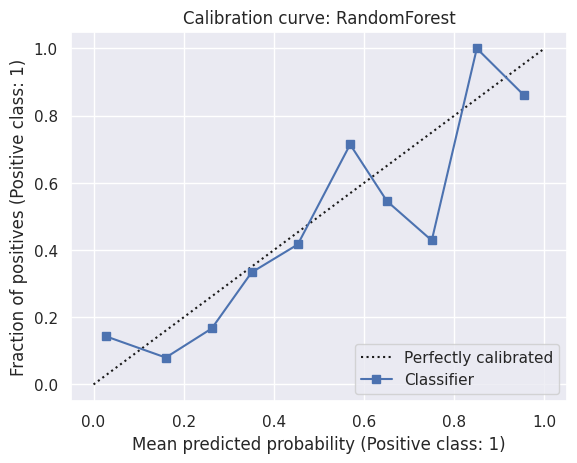

In [24]:
second_name = leaderboard.iloc[1]["model"]
second_pipe = pipelines[second_name]
print(f"Chosen model: {second_name}")

# 2nd best model
second_name = leaderboard.iloc[1]["model"]
evaluate_model(pipelines[second_name], X, y, second_name)

=== LogisticRegression Evaluation ===
ROC-AUC: 0.8703557312252965
Accuracy: 0.8268156424581006
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       110
           1       0.76      0.81      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

Brier score: 0.1354819217367425


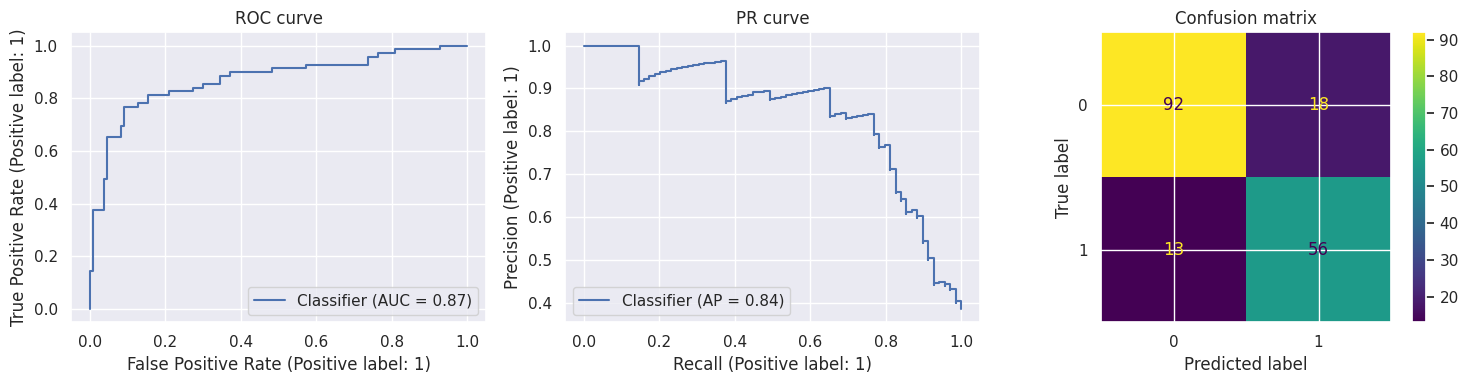

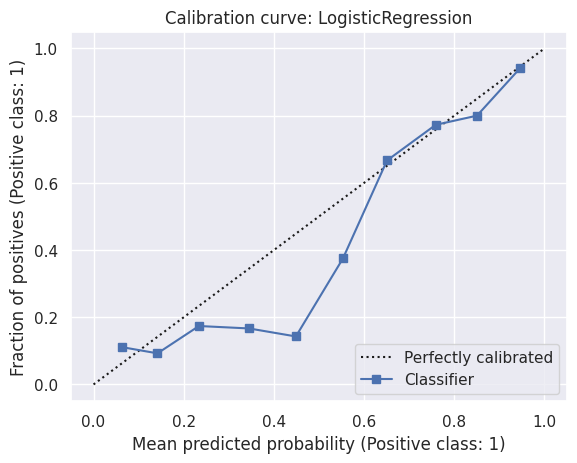

In [25]:
# Comparing with a weaker baseline
logit_name = "LogisticRegression"
evaluate_model(pipelines[logit_name], X, y, logit_name)

In [26]:
joblib.dump(best_pipe, BASE / "models/best_pipeline.joblib")
joblib.dump(second_pipe, BASE / "models/second_pipeline.joblib")
leaderboard.to_csv(BASE / "reports/leaderboard.csv", index=False)
print("Saved:", BASE / "models/best_pipeline.joblib")


Saved: /kaggle/working/models/best_pipeline.joblib
